# Lender Recommendation System 


The user supplies their Zip Code, and the algorithm finds past mortgage loans granted by nearby financial institutions. Then a several models are run at the institution level to predict the users' odds of getting a loan and the interest rate that they are likely to be offered. The system then recommends a list of lenders which are likely to offer the best odds combined with the lowest rate. 

## Data 

The data comes from the Home Mortgage Disclosure Act (HMDA). The law requires lenders to disclose information on their mortgage loan applications. The data is available annually and covers the entire country. For now, I focus on the DC-Maryland-Virginia metropolitan area from 2018 to 2020. This results in roughly 147 thousand mortgage application loans from 278 lending institutions covering over 200 Zip Codes. Data is limited to institutions which grant more than 100 loans to ensure sufficient observation to run institution-level models. Raw data files were large, so only the cleaned version of the data is liked here. 

In [110]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [34]:
hmda = pd.read_csv("hmda_full.csv")
hmda.head()

,activity_year,lei,action_taken,loan_amount,loan_to_value_ratio,interest_rate,rate_spread,total_loan_costs,loan_term,property_value,...,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units,ZIP,coapplicant,ethnicity,race,sex,Conventional
0,2020,DRMSV1Q0EKMEXLAU1P80,1,215000,62.000,2.875,-0.337,4051.86,360,345000,...,236,1351,1689,76,20007,0,NotHispanic,White,Male,1
1,2020,549300MFY0P4D234OB91,1,475000,90.000,2.500,-0.194,5474.58,360,525000,...,236,1351,1689,76,20007,0,NotHispanic,White,Female,1
2,2020,54930095UWUUXAWASB02,1,235000,43.934,2.625,-0.232,3579.00,360,545000,...,236,1351,1689,76,20007,0,NotHispanic,White,Female,1
3,2020,5493005PKOSG7MYX0B34,1,565000,80.000,2.875,-0.162,5319.95,360,715000,...,236,1351,1689,76,20007,0,NotAvailable,White,Female,1
4,2020,5493005PKOSG7MYX0B34,1,285000,72.424,2.750,-0.161,7317.91,360,395000,...,236,1351,1689,76,20007,0,NotHispanic,White,Female,1


In [35]:
hmda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141049 entries, 0 to 141048
Data columns (total 26 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   activity_year                      141049 non-null  int64  
 1   lei                                141049 non-null  object 
 2   action_taken                       141049 non-null  int64  
 3   loan_amount                        141049 non-null  int64  
 4   loan_to_value_ratio                141049 non-null  float64
 5   interest_rate                      130729 non-null  float64
 6   rate_spread                        130729 non-null  float64
 7   total_loan_costs                   130729 non-null  float64
 8   loan_term                          141049 non-null  int64  
 9   property_value                     141049 non-null  int64  
 10  income                             141049 non-null  int64  
 11  debt_to_income_ratio               1410

#### Distribution of mortgage loans across lenders 

Text(0, 0.5, 'Institutions')

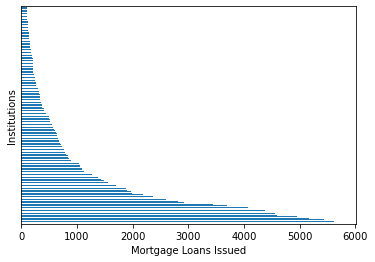

In [37]:
hmda['lei'].value_counts().plot(kind='barh')
plt.yticks([]) 
plt.xlabel('Mortgage Loans Issued')
plt.ylabel('Institutions')

#### Number of mortgage loans by Zip Code: DC, MD, VA, WV Metropolitan Area 

Text(0, 0.5, 'Zip Codes')

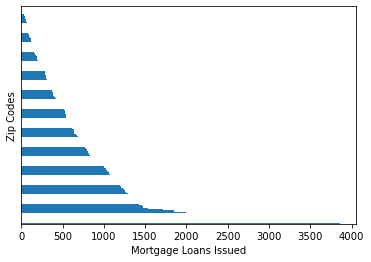

In [38]:
hmda['ZIP'].value_counts().plot(kind='barh')
plt.yticks([]) 
plt.xlabel('Mortgage Loans Issued')
plt.ylabel('Zip Codes')

#### Number of Lenders by Zip Code 

Text(0, 0.5, 'Zip Codes')

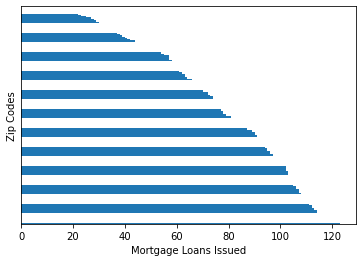

In [53]:
hmda.groupby('ZIP')['lei'].nunique().sort_values(ascending=False).plot(kind='barh')
plt.yticks([]) 
plt.xlabel('Mortgage Loans Issued')
plt.ylabel('Zip Codes')

#### Loans granted/rejected by race, sex, and ethnicity of applicant(s). 
The variable is called Action Taken. Rejected Mortgage Loan Application =0.  Accepted Mortgage Loan Application =1.

Text(0, 0.5, 'Percentage of Loans Rejected')

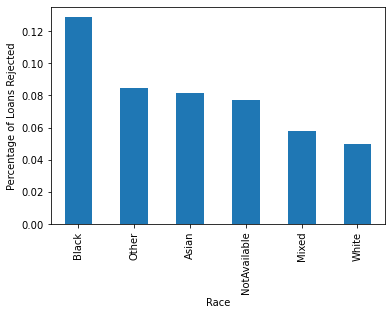

In [127]:
tbl1 = pd.crosstab(hmda.race, hmda.action_taken, normalize="index")
tbl1[0].sort_values(ascending=False).plot(kind='bar')
plt.xlabel("Race")
plt.ylabel('Proportion of Loans Rejected')

Text(0, 0.5, 'Percentage of Loans Rejected')

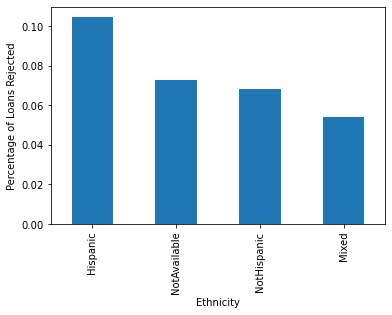

In [128]:
tbl2 = pd.crosstab(hmda.ethnicity, hmda.action_taken, normalize="index")
tbl2[0].sort_values(ascending=False).plot(kind='bar')
plt.xlabel("Ethnicity")
plt.ylabel('Proportion of Loans Rejected')



Text(0, 0.5, 'Proportion of Loans Rejected')

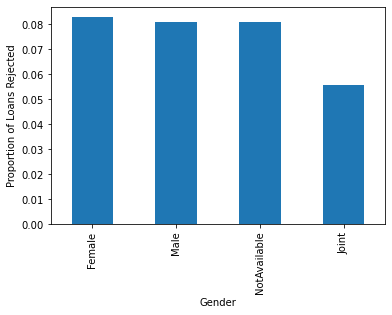

In [129]:
tbl3 = pd.crosstab(hmda.sex, hmda.action_taken, normalize="index")
tbl3[0].sort_values(ascending=False).plot(kind='bar')
plt.xlabel("Gender")
plt.ylabel('Proportion of Loans Rejected')


#### Distribution of Key Variables 

Text(0, 0.5, 'Freq')

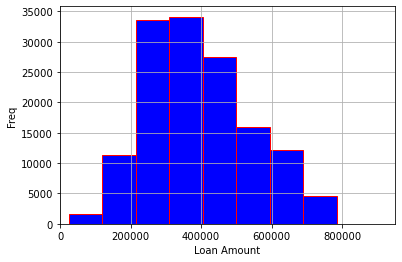

In [107]:
hmda.loan_amount.hist(color='b', edgecolor='red')
plt.xlim(xmin=0, xmax = 950000)
plt.xlabel("Loan Amount")
plt.ylabel('Freq')

Text(0, 0.5, 'Freq')

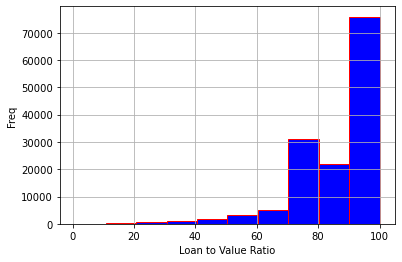

In [106]:
hmda.loan_to_value_ratio.hist(color='b', edgecolor='red')
plt.xlabel("Loan to Value Ratio")
plt.ylabel('Freq')

Text(0, 0.5, 'Freq')

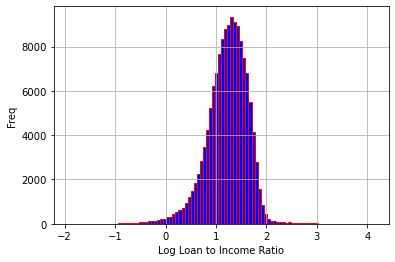

In [105]:
hmda['log_loan_to_income_ratio'] = np.log( hmda['loan_amount'] /  hmda['income'] * 0.001)

hmda.log_loan_to_income_ratio.hist(color='b', edgecolor='red',bins=100)
plt.xlabel("Log Loan to Income Ratio")
plt.ylabel('Freq')


Text(0, 0.5, 'Freq')

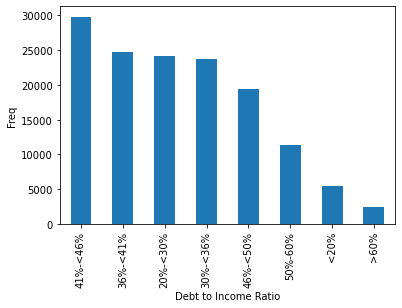

In [104]:
hmda['debt_to_income_ratio'].value_counts().plot(kind='bar')
plt.xlabel("Debt to Income Ratio")
plt.ylabel('Freq')

Text(0, 0.5, 'Freq')

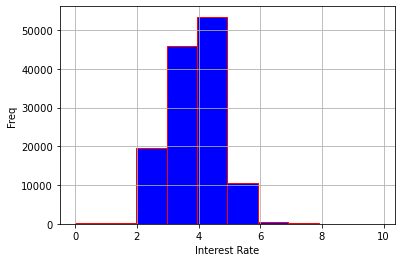

In [103]:
hmda.interest_rate.hist(color='b', edgecolor='red')
plt.xlabel("Interest Rate")
plt.ylabel('Freq')

<AxesSubplot:xlabel='loan_amount', ylabel='interest_rate'>

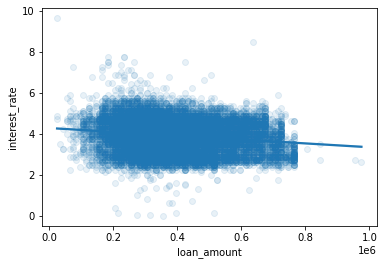

In [95]:
 sample_hmda= hmda.sample(frac=0.1)

#create scatterplot with regression line and confidence interval lines
sns.regplot(x="loan_amount", y="interest_rate",data=sample_hmda , scatter_kws={'alpha':0.1})

<AxesSubplot:xlabel='loan_to_value_ratio', ylabel='interest_rate'>

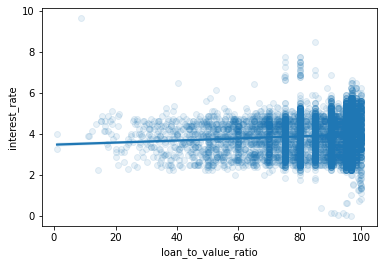

In [96]:
sns.regplot(x="loan_to_value_ratio", y="interest_rate",data=sample_hmda , scatter_kws={'alpha':0.1})

<AxesSubplot:xlabel='log_loan_to_income_ratio', ylabel='interest_rate'>

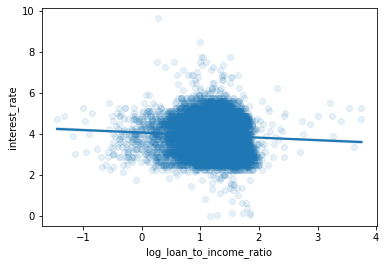

In [97]:
sns.regplot(x="log_loan_to_income_ratio", y="interest_rate",data=sample_hmda , scatter_kws={'alpha':0.1})

Text(0, 0.5, 'Mean Interest Rate')

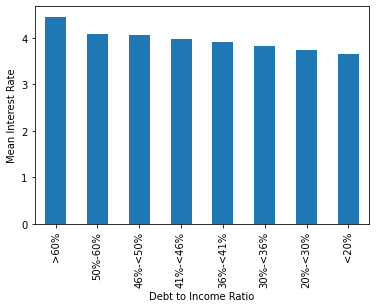

In [102]:
hmda.groupby('debt_to_income_ratio')["interest_rate"].mean().sort_values(ascending=False).plot(kind='bar')
plt.xlabel("Debt to Income Ratio")
plt.ylabel('Mean Interest Rate')